# Tutorial: context aware learning of multiple modalities with mmcontext

## Contents of Tutorial

This tutorial demonstrates how to use the mmcontext package to preprocess single-cell data. We'll walk through the steps of:

**Preprocessing**:
1. Loading the Dataset
2. Generating Embeddings
3. Normalizing Embeddings
4. Aligning Embeddings
5. Constructing the Dataset
6. Creating a Data Loader

**Model fitting**:
1. Initialize the model
2. Configure the loss
3. Train the model

### Preprocessing
#### 1. Loading the Dataset

The input data has to be an {class}`anndata.AnnData` object. First, we'll load the example dataset provided in data/small_cellxgene.h5ad. It is derived from the cellxgene census {cite:p}`czi2023cz` and contains cells of various tissues and celltypes from different studys. The scvi embedding included is provided by cellxgene and contains embeddings computed with the scvi variational autoencoder trained on the cellxgene corpus. It is a custom made dataset that contains data from various tissues originating from different datasets.

In [160]:
# Import necessary libraries
import anndata
import scanpy as sc

data_path = "../../data/demo/small_cellxgene.h5ad"
# Load the dataset
adata = anndata.read_h5ad(data_path)
# Display basic information about the dataset
# Log transformation for reconstruction
sc.pp.log1p(adata)
print(adata)

AnnData object with n_obs × n_vars = 5600 × 1000
    obs: 'soma_joinid', 'donor_id', 'disease', 'sex', 'dataset_id', 'cell_type', 'assay', 'tissue', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'is_primary_data'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    uns: 'log1p'
    obsm: 'metadata_tissue_assay_cell_type', 'scvi'


In [161]:
from mmcontext.pp.utils import split_anndata, remove_entries, consolidate_low_frequency_categories

# split anndata into train and test
train_adata, test_adata = split_anndata(adata, train_size=0.8)
remove_entries(train_adata)
remove_entries(test_adata)
# remove cells with less than 10 appearances

train_adata = consolidate_low_frequency_categories(
    train_adata, columns=["cell_type", "dataset_id"], threshold=5, remove=True
)
# remove cells with less than 10 appearances
test_adata = consolidate_low_frequency_categories(
    test_adata, columns=["cell_type", "dataset_id"], threshold=5, remove=True
)

mmcontext.pp.utils - INFO - No cells with zero variance found.
mmcontext.pp.utils - INFO - No cells with zero variance found.


c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\scanpy\preprocessing\_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\scanpy\preprocessing\_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


#### 2. Generate Embeddings

We will generate context embeddings based on the categorical metadata fields cell_type and tissue using the {class}`mmcontext.pp.CategoryEmbedder` class.
The method is based on creating an embedding of the individual categories of a cell with a text model. The `embeddings_file_path` points to a dictionary that contains embeddings for a range of cell types and tissues from the cellxgene corpus, thereby allowing the method to work without needing an API call. Only if some categories are not found in the dictionary the api will be used. If only a few are unknown, these will just be filled with a zero embedding. The `unkown_threshold` parameter controls how many new categories are needed to use the API. For that of course an API Key will be needed, which has to be set as an environmental variable "OPENAI_API_KEY". 

We will use the precomputed data embeddings stored in `adata.obsm['scvi']` as our data embeddings

In [162]:
# Import the CategoryEmbedder class
from mmcontext.pp import CategoryEmbedder, Embedder

# Specify the categories to embed
categories = ["cell_type"]
one_hot = False
# Initialize the CategoryEmbedder
category_embedder = CategoryEmbedder(
    metadata_categories=categories,
    model="text-embedding-3-small",
    combination_method="concatenate",
    embeddings_file_path="../../data/emb_dicts/category_embeddings_text-embedding-3-small_metadata_embeddings.pkl.gz",
    one_hot=one_hot,
)
# Initialize the Embedder without embedders
embedder = Embedder(context_embedder=category_embedder, data_embedder=None)

# Create embeddings using external embeddings
for adata in [train_adata, test_adata]:
    embedder.create_embeddings(adata, data_embeddings=adata.obsm["scvi"])
    # Confirm the shape of the context embeddings
    print("Context Embeddings Shape:", adata.obsm["c_emb"].shape)
    print("Data Embeddings Shape:", adata.obsm["d_emb"].shape)

mmcontext.pp.context_embedder - INFO - Loaded embeddings from file.
mmcontext.pp.context_embedder - INFO - Embeddings dictionary contains the following categories: dict_keys(['cell_type', 'tissue', 'assay']) with a total of 947 elements.
mmcontext.pp.embedder - INFO - Using external data embeddings provided.
mmcontext.pp.embedder - INFO - Creating context embeddings...
mmcontext.pp.context_embedder - INFO - Embeddings for 'cell_type' stored in adata.obsm['cell_type_emb']
mmcontext.pp.context_embedder - INFO - Combined context embeddings stored in adata.obsm['c_emb']
Context Embeddings Shape: (4278, 1536)
Data Embeddings Shape: (4278, 50)
mmcontext.pp.embedder - INFO - Using external data embeddings provided.
mmcontext.pp.embedder - INFO - Creating context embeddings...
mmcontext.pp.context_embedder - INFO - Embeddings for 'cell_type' stored in adata.obsm['cell_type_emb']
mmcontext.pp.context_embedder - INFO - Combined context embeddings stored in adata.obsm['c_emb']
Context Embeddings 

#### 3. Normalize Embeddings 

Now that the embeddings are created and stored in the adata object we can apply normalization. We will use the {class}`mmcontext.pp.MinMaxNormalizer` here. 

In [163]:
# Import the MinMaxNormalizer class
from mmcontext.pp import MinMaxNormalizer

# Initialize the MinMaxNormalizer
normalizer = MinMaxNormalizer()
# Normalize the embeddings
for adata in [train_adata, test_adata]:
    normalizer.normalize(adata)

    # Confirm that normalized embeddings are stored
    print("Normalized Data Embeddings Shape:", adata.obsm["d_emb_norm"].shape)
    print("Normalized Context Embeddings Shape:", adata.obsm["c_emb_norm"].shape)

mmcontext.pp.embedding_normalizer - INFO - Normalizing embeddings using min-max normalization...
Normalized Data Embeddings Shape: (4278, 50)
Normalized Context Embeddings Shape: (4278, 1536)
mmcontext.pp.embedding_normalizer - INFO - Normalizing embeddings using min-max normalization...
Normalized Data Embeddings Shape: (913, 50)
Normalized Context Embeddings Shape: (913, 1536)


#### 4. Aligning Embeddings

After normalization we will now use a {class}`mmcontext.pp.DimAligner` to make sure the dimensions of both data and context embeddings are equal, as this will be nescessary for the model. We will use the {class}`mmcontext.pp.PCAReducer` for this. If embeddings are larger than target latent dimension, they will be reduced via PCA. If there are smaller, padding with zeros will be applied. If using the {class}`mmcontext.pp.PCAReducer`, you can evaluate the principal components with some plots and metrics.

In [164]:
from omegaconf import DictConfig

# Create a DictConfig object for the configuration
config = DictConfig(
    {
        "evaluate_pca": True,
        "save_path": "pca_eval_oh",
        "scree_plot": True,
        "cumulative_variance_plot": True,
        "loadings_heatmap": True,
        "loadings_heatmap_options": {
            "threshold": 0,  # Only include loadings above this threshold
            "top_n_components": 64,  # Number of principal components to include in the heatmap
            "top_n_variables": 1000,  # Number of variables to display in the heatmap
        },
    }
)
# Configuration dictionary for PCA evaluation

if config.evaluate_pca and one_hot:
    config.one_hot_order = adata.uns["one_hot_order"]

In [165]:
# Import the PCAReducer class
from mmcontext.pp import PCAReducer

# Initialize the PCAReducer with the desired latent dimension
latent_dim = 64
aligner = PCAReducer(latent_dim=latent_dim, config=config)

# Align the embeddings
for adata in [train_adata, test_adata]:
    aligner.align(adata)

    # Confirm that aligned embeddings are stored
    print("Aligned Data Embeddings Shape:", adata.obsm["d_emb_aligned"].shape)
    print("Aligned Context Embeddings Shape:", adata.obsm["c_emb_aligned"].shape)

mmcontext.pp.dim_aligner - INFO - one_hot_order not provided. Using default feature indices.
mmcontext.pp.dim_aligner - INFO - Applied threshold: 0
mmcontext.pp.dim_aligner - INFO - Selected top 1000 variables based on importance.
mmcontext.pp.dim_aligner - INFO - Loadings heatmap saved to pca_eval_oh\loadings_heatmap.png
mmcontext.pp.dim_aligner - INFO - Loadings heatmap generation complete.
Aligned Data Embeddings Shape: (4278, 64)
Aligned Context Embeddings Shape: (4278, 64)
mmcontext.pp.dim_aligner - INFO - one_hot_order not provided. Using default feature indices.
mmcontext.pp.dim_aligner - INFO - Applied threshold: 0
mmcontext.pp.dim_aligner - INFO - Selected top 1000 variables based on importance.
mmcontext.pp.dim_aligner - INFO - Loadings heatmap saved to pca_eval_oh\loadings_heatmap.png
mmcontext.pp.dim_aligner - INFO - Loadings heatmap generation complete.
Aligned Data Embeddings Shape: (913, 64)
Aligned Context Embeddings Shape: (913, 64)


#### 5. Constructing the Dataset

Finally, we will construct a dataset using the aligned embeddings, suitable for training models with PyTorch.

In [166]:
# Import the DataSetConstructor class
from mmcontext.pp import DataSetConstructor

# The sequence length for the dataset. Since attention mechanisms will be used, samples can be grouped into sequences to perform attention within the sequence.
seq_length = 32
batch_size = 16
# Initialize the DataSetConstructor
train_dataset_constructor = DataSetConstructor(
    in_sample_id_key="soma_joinid", chunk_size=seq_length * batch_size, batch_size=batch_size
)
test_dataset_constructor = DataSetConstructor(
    in_sample_id_key="soma_joinid", chunk_size=seq_length * batch_size, batch_size=batch_size
)

# Add the AnnData object to the dataset
train_dataset_constructor.add_anndata(train_adata)
test_dataset_constructor.add_anndata(test_adata)


# Construct the dataset
train_dataset = train_dataset_constructor.construct_dataset(seq_length=seq_length)
test_dataset = test_dataset_constructor.construct_dataset(seq_length=seq_length)

#### 6. Create a Dataloader
Create a pyTorch Dataloader which can be iterated over

In [167]:
from torch.utils.data import DataLoader

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
# For now use the test data as validation data
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Iterate over DataLoader and verify batch shapes
for batch in train_loader:
    data_embeddings = batch["data_embedding"]  # Shape: (batch_size, seq_length, embedding_dim)
    context_embeddings = batch["context_embedding"]  # Shape: (batch_size, seq_length, embedding_dim)
    sample_ids = batch["sample_id"]  # Shape: (batch_size, seq_length)
    raw_data = batch["raw_data"]  # Shape: (batch_size, seq_length, num_features)

    print(data_embeddings.shape)
    print(context_embeddings.shape)
    print(sample_ids.shape)
    print(raw_data.shape)
    break  # Only need to check the first batch

torch.Size([16, 32, 64])
torch.Size([16, 32, 64])
torch.Size([16, 32])
torch.Size([16, 32, 1000])


### Model fitting
#### 1. Initializing the Model
The {class} `mmcontext.engine.MMContextEncoder` is the main encoder which will be used to create embeddings based on the available data and context embeddings. It's structure is flexible and is build upon torchs {class} `torch.nn.TransformerEncoder` which creates stacks of the {class} `mmcontext.engine.CustomTransformerEncoderLayer` which can be configured to be 

1. An MLP only model
2. To apply self attention (use_self_attention = True)
3. To apply cross attention (use_cross_attention = True)
4. To use both self and cross attention (both True)

The model takes two matrix inputs, `in_main` and `in_cross`. in_main will be passed through the MLP and optionally the self-attention layers, while in_cross is only used if cross-attention is used. In the end the model outputs embeddings of the same shape as in_main, updated based on the learning objective. The inputs are handled in the {class} `mmcontext.engine.Trainer` in dependancy with the settings used for the loss. 

In [168]:
from mmcontext.engine import MMContextEncoder, ZINBDecoder

hidden_dim = 64
num_layers = 1
num_heads = 1
encoder = MMContextEncoder(
    embedding_dim=latent_dim,  # this has to be the same dimension as the latent dimension of the aligner
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    num_heads=num_heads,
    use_self_attention=False,
    use_cross_attention=False,
    activation="relu",
    dropout=0.1,
)
decoder = ZINBDecoder(
    input_dim=latent_dim,
    hidden_dims=[64, 128],
    output_dim=train_adata.shape[1],  # number of genes
)

mmcontext.engine.models - INFO - MMContextEncoder initialized with embedding_dim = 64, num_layers = 1, use_self_attention = False, use_cross_attention = False.
ZINBDecoder
mmcontext.engine.models - INFO - ZINBDecoder initialized with input_dim = 64, hidden_dims = [64, 128], output_dim = 1000.


#### 2. Configure the loss
The loss function is a central part of this project. The loss is implemented to be extendable and customizable by having a {class} `mmcontext.engine.LossManager` which you can use to add different losses to and which will be passed to the {class} `mmcontext.engine.Trainer` to compute the total loss (as a weighted average of the components) during Training. The current main implementation of a {class} `mmcontext.engine.LossFunction` is the {class} `mmcontext.engine.ContrastiveLoss`, which is a custom approach to contrastive learning. It's main configuration parameters are `target_mode` and `current_mode` which refer to the way in which the target similarity matrix and the current (during model training) similarity matrix are constructed. For example if `target_mode = 'context_context'`, the original context embeddings are used to create the target similarity matrix. Therefore during training, the loss is calcualted as the mean squared error between the current similarity matrix and the one based on the context. If `current_mode = 'data_data'`, the model would learn to find representations of the data that represent similarity found in the respective context.  

In [169]:
from mmcontext.engine import LossManager, ContrastiveLoss, ZINBLoss

loss_manager = LossManager()
loss_manager.add_loss(ContrastiveLoss(target_mode="infoNCE", current_mode="data_context", similarity_metric="cosine"))
loss_manager.add_loss(ZINBLoss(), weight=0.01)

mmcontext.engine.losses - INFO - Adding loss function: ContrastiveLoss(target_mode=infoNCE, current_mode=data_context, similarity_metric=cosine) with weight 1.00
mmcontext.engine.losses - INFO - Adding loss function: ZINBLoss with weight 0.01


#### 3. Train the Model
The Trainer uses the defined model and loss the conduct training, aiming to iterativly minimize the loss. The {func} `mmcontext.engine.Trainer.fit` method can take a training and a validation dataloader as input. If a validation loader is given and a save_path is used, the weights of the best performing model can be saved to file. The {class} `mmcontext.engine.MMContextEncoder` has a method `load` to load weights from file.
Per default data embeddings are used for in_main while context embeddings are used as in_cross.

In [181]:
from mmcontext.engine import Trainer
import torch

model_parameters = list(encoder.parameters()) + list(decoder.parameters())
trainer = Trainer(
    encoder=encoder,
    decoder=decoder,
    loss_manager=loss_manager,
    optimizer=torch.optim.Adam(model_parameters),
    input_embeddings={"main": "data_embedding", "cross": "context_embedding"},
    temperature=0.07,
)

mmcontext.engine.trainer - INFO - Temperature: 0.07


In [182]:
from mmcontext.eval.system_usage import SystemMonitor

monitor = SystemMonitor(interval=0.1)
monitor.start()

res = trainer.fit(train_loader, val_loader, epochs=10, save=True)

monitor.stop()

mmcontext.eval.system_usage - INFO - No NVIDIA GPU detected or pynvml not installed.
mmcontext.eval.system_usage - INFO - No supported GPU detected.
mmcontext.engine.trainer - INFO - Starting Epoch 1/10
mmcontext.engine.trainer - INFO - Batch 9/9, Loss: 7.6965
mmcontext.engine.trainer - INFO - Training Epoch Complete. Average Loss: 8.6776
mmcontext.engine.trainer - INFO - Validation Complete. Average Loss: 9.1421
mmcontext.engine.trainer - INFO - Epoch 1/10 - Train Loss: 8.6776, Val Loss: 9.1421
mmcontext.engine.models - INFO - Saving model state dictionary to best_encoder_weights.pth
mmcontext.engine.trainer - INFO - Validation loss improved. Encoder weights saved in current working dir.
mmcontext.engine.models - INFO - Saving model state dictionary to best_decoder_weights.pth
mmcontext.engine.trainer - INFO - Validation loss improved. Decoder weights saved in current working dir.
mmcontext.engine.trainer - INFO - Temperature: 0.07
mmcontext.engine.trainer - INFO - Starting Epoch 2/10

In [172]:
monitor.print_summary()


System Resource Usage Summary:
CPU Usage (mean/max cores): 26.41/57.12
Core Utilization (mean/max % per core): 26.41/100.00%
Memory Usage (mean/max GB): 18.14/18.16 GB
Total System Memory: 31.44 GB
Disk Read Rate (mean/max MB/s): 0.05/4.14 MB/s
Disk Write Rate (mean/max MB/s): 1.57/12.69 MB/s
No supported GPU detected.
Number of Threads (mean/max): 62.00/62


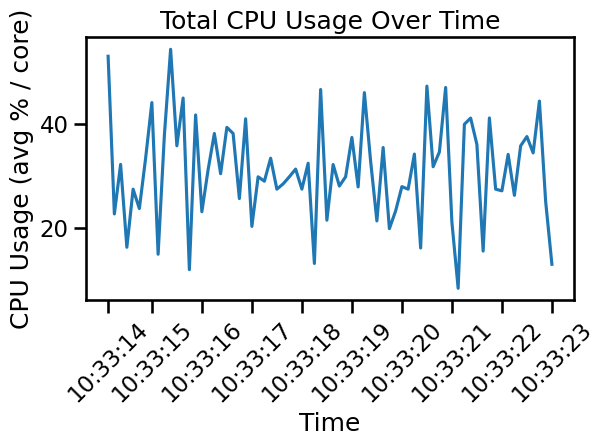

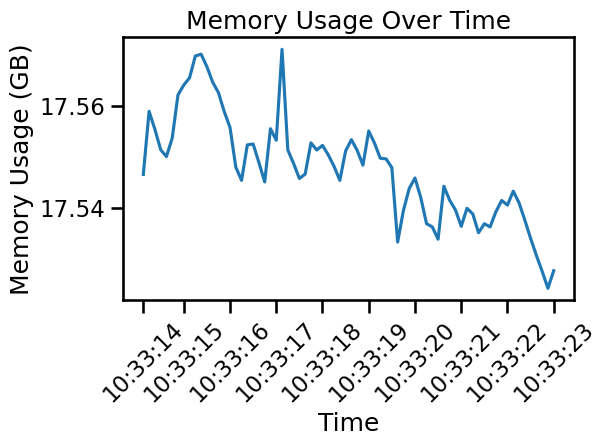

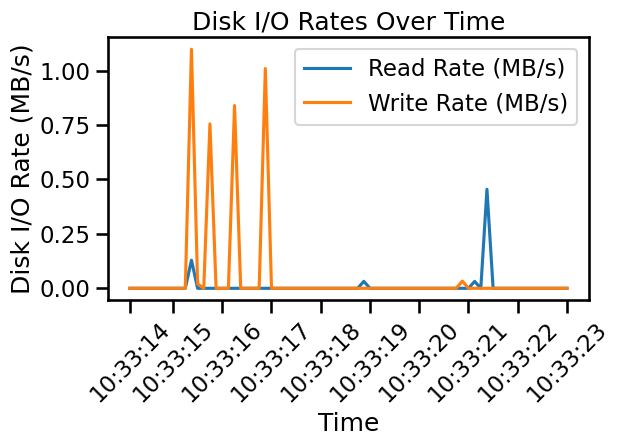

In [14]:
monitor.plot_metrics()

In [265]:
import numpy as np

# add a little bit of noise to the test data because otherwise hvg selection evaluation has a problem with the same values
# test_adata2 = test_adata.copy()
# test_adata2.X += np.random.normal(0, 1e-10, size=test_adata2.X.shape)
# The fitted model can be used to create universial embeddings
encoder.load(file_path="best_encoder_weights.pth")
decoder.load(file_path="best_decoder_weights.pth")
trainer = Trainer(
    encoder=encoder, decoder=decoder, input_embeddings={"main": "data_embedding", "cross": "context_embedding"}
)
trainer.infer_adata(
    test_adata,
    sample_id_key="soma_joinid",
    seq_length=seq_length,
    batch_size=batch_size,
    chunk_size=seq_length * batch_size,
    output_zarr_path="inferred_adata.zarr",
)

mmcontext.engine.models - INFO - Loading model state dictionary from best_encoder_weights.pth
mmcontext.engine.models - INFO - Loading model state dictionary from best_decoder_weights.pth


C:\Users\mengerj\repos\mmcontext\src\mmcontext\engine\trainer.py:562: ImplicitModificationWarning: Setting element `.obsm['mod_emb']` of view, initializing view as actual.
  adata.obsm["mod_emb"] = embeddings_zarr
... storing 'dataset_id' as categorical
... storing 'cell_type' as categorical


In [266]:
inferred_adata = anndata.read_zarr("inferred_adata.zarr")

#### 4. Evaluate the embeddings
In order to assess the quality of the embeddings, the {class}`mmcontext.eval.scibEvaluator` can be used. It computes metrics from the scib package {cite:p}`luecken2022benchmarking` in order to asess bioconservation and batch integration. This can also be judged visualy with a umap.

In [194]:
from mmcontext.pl.plotting import plot_umap
from mmcontext.eval import scibEvaluator

# Initialize scibEvaluator
evaluator = scibEvaluator(
    adata=inferred_adata, batch_key="dataset_id", label_key="cell_type", embedding_key=["scvi", "mod_emb"]
)

In [18]:
from mmcontext.eval.system_usage import SystemMonitor

monitor = SystemMonitor(interval=1)
monitor.start()

res = evaluator.evaluate()

monitor.stop()

mmcontext.eval.system_usage - INFO - No NVIDIA GPU detected or pynvml not installed.
mmcontext.eval.system_usage - INFO - No supported GPU detected.
mmcontext.eval.evaluate_scib - INFO - Computing metrics on raw data...
mmcontext.eval.evaluate_scib - INFO - Computing PCA on all genes...


c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


resolution: 0.1, nmi: 0.35901558912668347
resolution: 0.2, nmi: 0.45915112277877035
resolution: 0.3, nmi: 0.4859639436629142
resolution: 0.4, nmi: 0.49269851308277557
resolution: 0.5, nmi: 0.568312203044516
resolution: 0.6, nmi: 0.5933170420766529
resolution: 0.7, nmi: 0.5929964924135396
resolution: 0.8, nmi: 0.6266436211030942
resolution: 0.9, nmi: 0.6271332523632753
resolution: 1.0, nmi: 0.6204652214934034
resolution: 1.1, nmi: 0.6259036062876815
resolution: 1.2, nmi: 0.6259036062876815
resolution: 1.3, nmi: 0.6264234557427323
resolution: 1.4, nmi: 0.6292998118162706
resolution: 1.5, nmi: 0.6443600325154707
resolution: 1.6, nmi: 0.647911767256913
resolution: 1.7, nmi: 0.6538189898742353
resolution: 1.8, nmi: 0.6483006161348477
resolution: 1.9, nmi: 0.6471575530975628
resolution: 2.0, nmi: 0.6484421127764088
optimised clustering against cell_type
optimal cluster resolution: 1.7
optimal score: 0.6538189898742353
isolated labels: no more than 1 batches per label
isolated labels: no more

c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\anndata\_core\anndata.py:1032: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub[k] = df_sub[k].cat.remove_unused_categories()
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\anndata\_core\anndata.py:1032: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub[k] = df_sub[k].cat.remove_unused_categories()


mean silhouette per group:                                         silhouette_score
group                                                   
B cell                                          0.772647
CD4-positive, alpha-beta T cell                 0.730210
CD8-positive, alpha-beta T cell                 0.716390
T cell                                          0.555234
alveolar macrophage                             0.800140
astrocyte                                       0.722188
capillary endothelial cell                      0.786995
classical monocyte                              0.748061
endothelial cell                                0.896573
epithelial cell of proximal tubule              0.826967
erythrocyte                                     0.665241
fibroblast                                      0.666483
macrophage                                      0.692861
malignant cell                                  0.483475
microglial cell                                 0.513866
mono

C:\Users\mengerj\AppData\Local\Programs\Python\Python310\lib\tempfile.py:860: ResourceWarning: Implicitly cleaning up <TemporaryDirectory 'C:\\Users\\mengerj\\AppData\\Local\\Temp\\lisi_lhsmnfs_'>
  _warnings.warn(warn_message, ResourceWarning)
C:\Users\mengerj\AppData\Local\Programs\Python\Python310\lib\tempfile.py:860: ResourceWarning: Implicitly cleaning up <TemporaryDirectory 'C:\\Users\\mengerj\\AppData\\Local\\Temp\\lisi_48c59z1x'>
  _warnings.warn(warn_message, ResourceWarning)
C:\Users\mengerj\AppData\Local\Programs\Python\Python310\lib\tempfile.py:860: ResourceWarning: Implicitly cleaning up <TemporaryDirectory 'C:\\Users\\mengerj\\AppData\\Local\\Temp\\lisi_uu9h2je_'>
  _warnings.warn(warn_message, ResourceWarning)
C:\Users\mengerj\AppData\Local\Programs\Python\Python310\lib\tempfile.py:860: ResourceWarning: Implicitly cleaning up <TemporaryDirectory 'C:\\Users\\mengerj\\AppData\\Local\\Temp\\lisi_0kcrhj8d'>
  _warnings.warn(warn_message, ResourceWarning)


kidney epithelial cell: 0.625
Compute neighbors on rep scvi
luminal adaptive secretory precursor cell of mammary gland: 0.0784313725490196
Compute neighbors on rep scvi
luminal hormone-sensing cell of mammary gland: 0.16216216216216217
Compute neighbors on rep scvi
macroglial cell: 0.125
Compute neighbors on rep scvi
mature NK T cell: 0.13636363636363635
Compute neighbors on rep scvi
mesenchymal cell: 0.08888888888888889
Compute neighbors on rep scvi
myeloid cell: 0.34285714285714286
Compute neighbors on rep scvi
myoepithelial cell of mammary gland: 0.4074074074074074
Compute neighbors on rep scvi
neoplastic cell: 0.15873015873015872
Compute neighbors on rep scvi
neural cell: 0.4634146341463415
Compute neighbors on rep scvi
neuroblast (sensu Vertebrata): 0.21052631578947367
Compute neighbors on rep scvi
perivascular cell: 0.1935483870967742
Compute neighbors on rep scvi
regular ventricular cardiac myocyte: 0.7916666666666666
Compute neighbors on rep scvi
retinal ganglion cell: 0.263157

We can also compare the reconstructed matrix and the original matrix. We do this by computing a variety of data properties and comparing them between orignal and reconstructed data

In [302]:
# Initialize the DataProperties object
from mmcontext.eval import DataProperties

dp = DataProperties(predefined_subset="microbiome")

In [303]:
dp.add_original_data(test_adata.X.toarray())

mmcontext.eval.data_properties - INFO - Using predefined microbiome subset.
mmcontext.eval.data_properties - WARNING - Method get_colSums not found.
mmcontext.eval.data_properties - WARNING - Method get_rowCorr not found.
mmcontext.eval.data_properties - WARNING - Method get_colCorr not found.


c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [ ]:
# Make reconstructed data and add it to the DataProperties object
for _i in range(0, 5):
    trainer.infer_adata(
        test_adata,
        sample_id_key="soma_joinid",
        seq_length=seq_length,
        batch_size=batch_size,
        chunk_size=seq_length * batch_size,
        output_zarr_path="inferred_adata.zarr",
    )
    inferred_adata = anndata.read_zarr("inferred_adata.zarr")
    dp.add_reconstructed_data(inferred_adata.layers["reconstructed"])

C:\Users\mengerj\repos\mmcontext\src\mmcontext\engine\trainer.py:562: ImplicitModificationWarning: Setting element `.obsm['mod_emb']` of view, initializing view as actual.
  adata.obsm["mod_emb"] = embeddings_zarr
... storing 'dataset_id' as categorical
... storing 'cell_type' as categorical


mmcontext.eval.data_properties - INFO - Using predefined microbiome subset.
mmcontext.eval.data_properties - WARNING - Method get_colSums not found.
mmcontext.eval.data_properties - WARNING - Method get_rowCorr not found.
mmcontext.eval.data_properties - WARNING - Method get_colCorr not found.


c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\mengerj\repos\mmcontext\src\mmcontext\eval\data_properties.py:947: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  seed_used = corr_res["seed"]
C:\Users\mengerj\repos\mmcontext\src\mmcontext\eval\data_properties.py:1093: RuntimeWarning: Mean of empty slice
  return {"res": sd_corr, "seed": corr_res["seed"]}
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\U

mmcontext.eval.data_properties - INFO - Using predefined microbiome subset.
mmcontext.eval.data_properties - WARNING - Method get_colSums not found.
mmcontext.eval.data_properties - WARNING - Method get_rowCorr not found.
mmcontext.eval.data_properties - WARNING - Method get_colCorr not found.


c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\mengerj\repos\mmcontext\src\mmcontext\engine\trainer.py:562: ImplicitModificationWarning: Setting element `.obsm['mod_emb']` of view, initializing view

mmcontext.eval.data_properties - INFO - Using predefined microbiome subset.
mmcontext.eval.data_properties - WARNING - Method get_colSums not found.
mmcontext.eval.data_properties - WARNING - Method get_rowCorr not found.
mmcontext.eval.data_properties - WARNING - Method get_colCorr not found.


c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\mengerj\repos\mmcontext\src\mmcontext\engine\trainer.py:562: ImplicitModificationWarning: Setting element `.obsm['mod_emb']` of view, initializing view

mmcontext.eval.data_properties - INFO - Using predefined microbiome subset.
mmcontext.eval.data_properties - WARNING - Method get_colSums not found.
mmcontext.eval.data_properties - WARNING - Method get_rowCorr not found.
mmcontext.eval.data_properties - WARNING - Method get_colCorr not found.


c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\mengerj\repos\mmcontext\src\mmcontext\engine\trainer.py:562: ImplicitModificationWarning: Setting element `.obsm['mod_emb']` of view, initializing view

mmcontext.eval.data_properties - INFO - Using predefined microbiome subset.
mmcontext.eval.data_properties - WARNING - Method get_colSums not found.
mmcontext.eval.data_properties - WARNING - Method get_rowCorr not found.
mmcontext.eval.data_properties - WARNING - Method get_colCorr not found.


c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [305]:
# simulate new data and perform the same procedure
# This could be a different test dataset
test_adata2 = test_adata.copy()
test_adata2.X += np.random.normal(0, 1e-6, size=test_adata2.X.shape)
dp.add_original_data(test_adata.X.toarray())

mmcontext.eval.data_properties - INFO - Using predefined microbiome subset.
mmcontext.eval.data_properties - WARNING - Method get_colSums not found.
mmcontext.eval.data_properties - WARNING - Method get_rowCorr not found.
mmcontext.eval.data_properties - WARNING - Method get_colCorr not found.


c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\anndata\_core\storage.py:85: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_functi

In [ ]:
for _i in range(0, 5):
    # Pass through the model
    trainer.infer_adata(
        test_adata2,
        sample_id_key="soma_joinid",
        seq_length=seq_length,
        batch_size=batch_size,
        chunk_size=seq_length * batch_size,
        output_zarr_path="inferred_adata.zarr",
    )
    inferred_adata = anndata.read_zarr("inferred_adata.zarr")
    dp.add_reconstructed_data(inferred_adata.layers["reconstructed"])

C:\Users\mengerj\repos\mmcontext\src\mmcontext\engine\trainer.py:562: ImplicitModificationWarning: Setting element `.obsm['mod_emb']` of view, initializing view as actual.
  adata.obsm["mod_emb"] = embeddings_zarr
... storing 'dataset_id' as categorical
... storing 'cell_type' as categorical


mmcontext.eval.data_properties - INFO - Using predefined microbiome subset.
mmcontext.eval.data_properties - WARNING - Method get_colSums not found.
mmcontext.eval.data_properties - WARNING - Method get_rowCorr not found.
mmcontext.eval.data_properties - WARNING - Method get_colCorr not found.


c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\mengerj\repos\mmcontext\src\mmcontext\eval\data_properties.py:947: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  seed_used = corr_res["seed"]
C:\Users\mengerj\repos\mmcontext\src\mmcontext\eval\data_properties.py:1093: RuntimeWarning: Mean of empty slice
  return {"res": sd_corr, "seed": corr_res["seed"]}
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\U

mmcontext.eval.data_properties - INFO - Using predefined microbiome subset.
mmcontext.eval.data_properties - WARNING - Method get_colSums not found.
mmcontext.eval.data_properties - WARNING - Method get_rowCorr not found.
mmcontext.eval.data_properties - WARNING - Method get_colCorr not found.


C:\Users\mengerj\repos\mmcontext\src\mmcontext\eval\data_properties.py:947: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  seed_used = corr_res["seed"]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\mengerj\repos\mmcontext\src\mmcontext\engine\trainer.py:562: ImplicitModificationWarning: Setting element `.obsm['mod_emb']` of view, initializing view as actual.
  adata.obsm["mod_emb"] = embeddings_zarr
... storing 'dataset_id' as categorical
... storing 'cell_type' as categorical


mmcontext.eval.data_properties - INFO - Using predefined microbiome subset.
mmcontext.eval.data_properties - WARNING - Method get_colSums not found.
mmcontext.eval.data_properties - WARNING - Method get_rowCorr not found.
mmcontext.eval.data_properties - WARNING - Method get_colCorr not found.


c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\mengerj\repos\mmcontext\src\mmcontext\engine\trainer.py:562: ImplicitModificationWarning: Setting element `.obsm['mod_emb']` of view, initializing view

mmcontext.eval.data_properties - INFO - Using predefined microbiome subset.
mmcontext.eval.data_properties - WARNING - Method get_colSums not found.
mmcontext.eval.data_properties - WARNING - Method get_rowCorr not found.
mmcontext.eval.data_properties - WARNING - Method get_colCorr not found.


c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\mengerj\repos\mmcontext\src\mmcontext\eval\data_properties.py:947: ConstantInputWarning: An input array is constant; the correlation coefficient is not

mmcontext.eval.data_properties - INFO - Using predefined microbiome subset.
mmcontext.eval.data_properties - WARNING - Method get_colSums not found.
mmcontext.eval.data_properties - WARNING - Method get_rowCorr not found.
mmcontext.eval.data_properties - WARNING - Method get_colCorr not found.


c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [294]:
dp.compare_data_properties()

{'mean': np.float64(0.35670237467181864),
 'sd': np.float64(0.04418657274838522),
 'res_df':   og_id recon_id  LinCoefPoly2  maxColSums  sdColCorr  minColSums  nFeatures  \
 0     1        0      0.318724    0.200469        NaN         0.0   0.027116   
 1     1        1      0.217778    0.248386        NaN         0.0   0.027116   
 2     1        2      0.352436    0.211640        NaN         0.0   0.027116   
 3     1        3      0.331018    0.274332        NaN         0.0   0.027116   
 4     1        4      0.325308    0.253810        NaN         0.0   0.027116   
 5     2        5      0.239258    0.260618        NaN         0.0   0.027116   
 6     2        6      0.305909    0.305674        NaN         0.0   0.027116   
 7     2        7      0.322934    0.279855        NaN         0.0   0.027116   
 8     2        8      0.336334    0.252452        NaN         0.0   0.027116   
 9     2        9      0.360480    0.266773        NaN         0.0   0.027116   
 
         q95  m

In [308]:
dp.plot_metrics()

TypeError: expected str, bytes or os.PathLike object, not NoneType

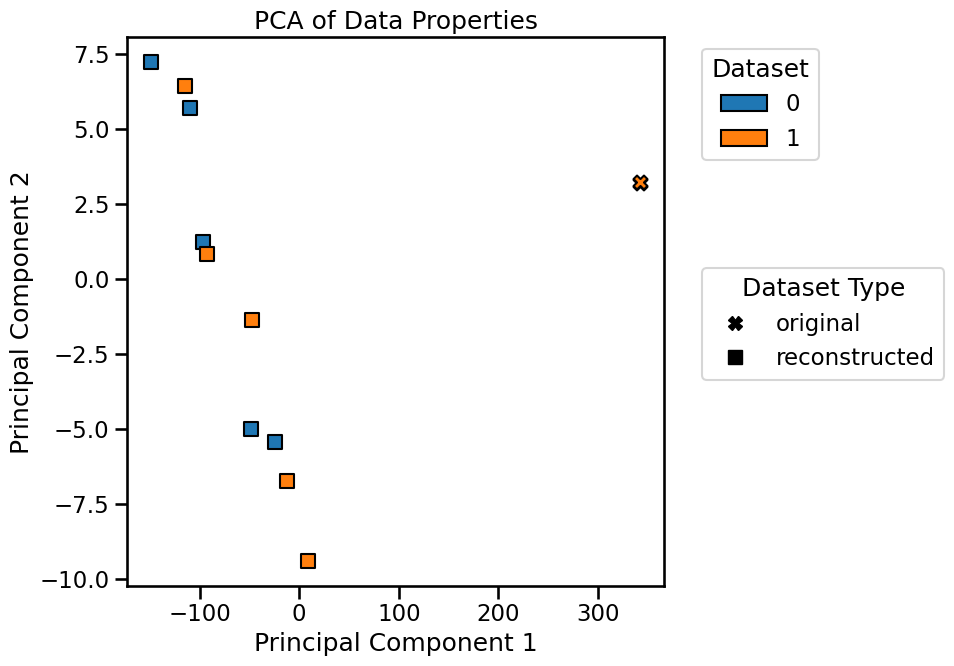

In [318]:
dp.plot_pca()

mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.


c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Figure size 800x800 with 0 Axes>

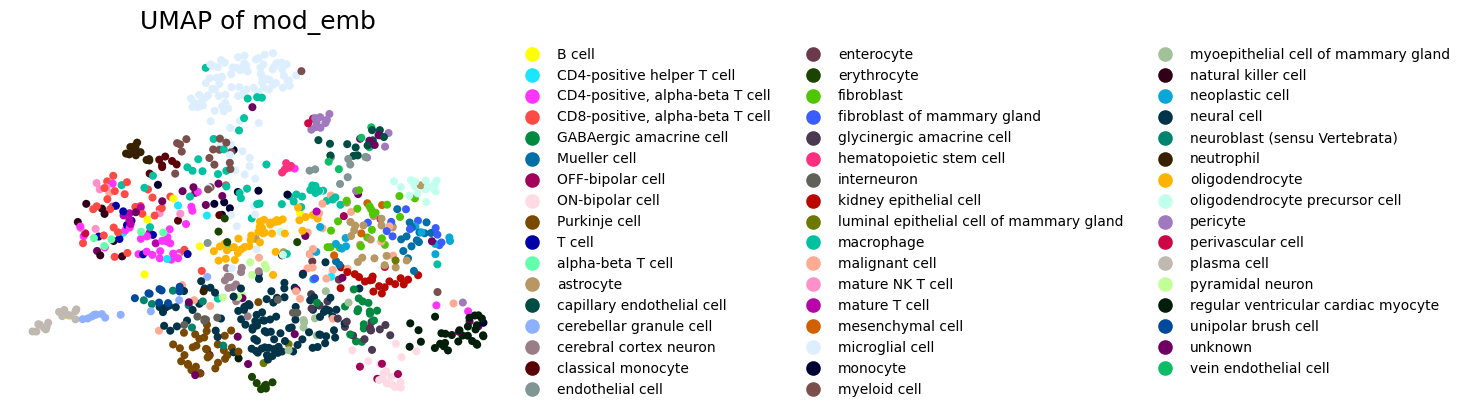

mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.


In [40]:
plot_umap(inferred_adata, color_group="cell_type", embedding_key="mod_emb", save_plot=False)

mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.


<Figure size 800x800 with 0 Axes>

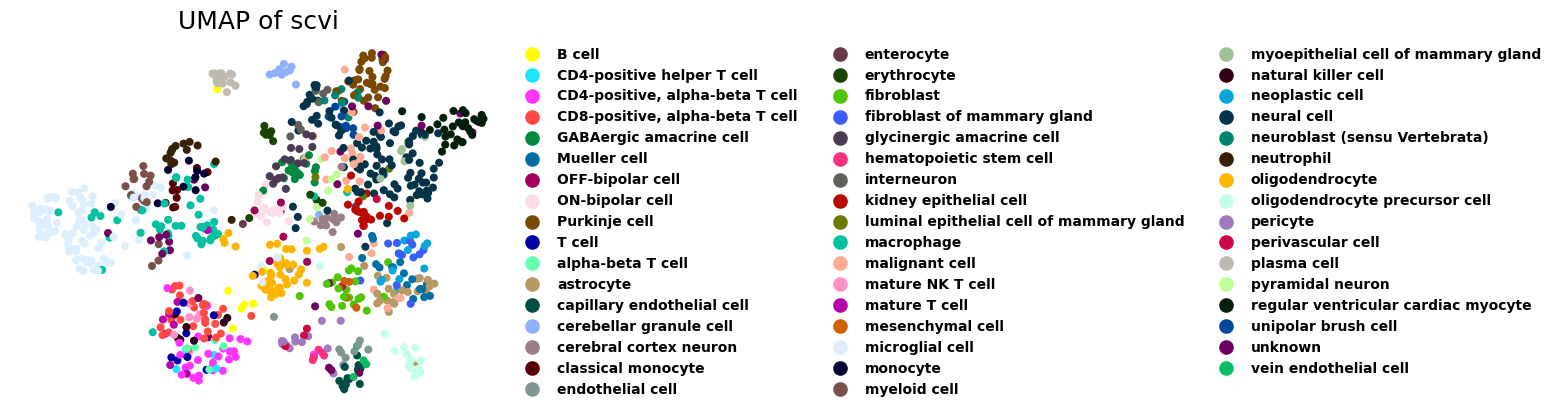

mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.


In [41]:
plot_umap(inferred_adata, color_group="cell_type", embedding_key="scvi", save_plot=False)